In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, multivariate_normal
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tqdm import trange
from densratio import densratio
from numpy import linalg as la
import matplotlib.pyplot as plt
from densratio import densratio
np.random.seed(42)
import momentchi2 as mchi

# Functions

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso

    

def density_ratio_estimate_prob_RF(D_nu, D_de, n_estimators=100):
    l_nu = np.ones(len(D_nu))
    l_de = np.zeros(len(D_de))
    
    l = np.concatenate((l_nu, l_de))
    D = np.concatenate((D_nu, D_de))
    
    # Fit Random Forest model
    model = RandomForestClassifier()
    model.fit(D, l)
    
    # Get density ratios for all samples
    density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
    
    return density_ratios


from sklearn.linear_model import LogisticRegressionCV

def density_ratio_estimate_prob_LR(D_nu, D_de, true_density = None,Z_known = True):
    if Z_known == False:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Adding cross terms
        cross_terms_de = []
        n_covariates = D_de.shape[1]
        for i in range(n_covariates):
            for j in range(i, n_covariates):
                cross_term = D_de[:, i] * D_de[:, j]
                cross_terms_de.append(cross_term)
        cross_terms_de = np.array(cross_terms_de).T

        cross_terms_nu = []
        n_covariates = D_nu.shape[1]
        for i in range(n_covariates):
            for j in range(i , n_covariates):
                cross_term = D_nu[:, i] * D_nu[:, j]
                cross_terms_nu.append(cross_term)
        cross_terms_nu = np.array(cross_terms_nu).T


        D_nu_with_cross_terms = np.concatenate((D_nu, cross_terms_nu),axis = 1)
        D_de_with_cross_terms = np.concatenate((D_de, cross_terms_de), axis = 1)
        D_with_cross_terms = np.concatenate((D_nu_with_cross_terms, D_de_with_cross_terms))

        # Fit logistic model with cross terms
        C = 0.1
        model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
        model.fit(D_with_cross_terms, l)

        # Get density ratios for samples in D_de
        density_ratios = (model.predict_proba(D_de_with_cross_terms)[:, 1] / model.predict_proba(D_de_with_cross_terms)[:, 0]) * (len(D_de) / len(D_nu))
        
    if Z_known == True:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Fit logistic model with cross terms

        model = LogisticRegressionCV(penalty='l2', cv = 2)
        model.fit(D, l)
        print(model.score(D,l))
        # Get density ratios for samples in D_de
        v_density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
        density_ratios = v_density_ratios * np.array(true_density)
    return density_ratios





from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

def est_v_ratio(X_s, Z_s, V_s, X_t, Z_t, V_t):
    # Generate cross-terms between X_s and Z_s
    # concatenate the data and fit the lasso model
    D_s = np.concatenate((Z_s, X_s), axis=1)
    model_s = LassoCV(cv=5)
    model_s.fit(D_s, V_s.ravel())
    # print(np.var(V_s))
    # Estimate the variance of the V|X,Z model
    V_pred_s = model_s.predict(D_s)
    residual_s = V_s.ravel() - V_pred_s
    est_var_s = np.var(residual_s)
    # print(est_var_s)
    
    # print(model_s.coef_)
    # Compute the R^2 score for the source model
    r2_s = r2_score(V_s, V_pred_s)
    # print(f"Source Model R^2 Score: {r2_s}")
    
    # Estimate the V probability for each sample
    V_s_prob = norm.pdf(V_s.ravel(), loc=V_pred_s, scale=np.sqrt(est_var_s))
    
    # Generate cross-terms between X_t and Z_t
    
    D_t = np.concatenate((Z_t, X_t), axis=1)
    # print(np.var(V_t))
    model_t = LassoCV(cv=5)
    model_t.fit(D_t, V_t.ravel())
    
    V_pred_t = model_t.predict(D_t)
    residual_t = V_t.ravel() - V_pred_t
    est_var_t = np.var(residual_t)
    
    # print(est_var_t)
    V_pred_st = model_t.predict(D_s)
    # print(model_t.coef_)
    # Compute the R^2 score for the target model
    r2_t = r2_score(V_t, V_pred_t)
    # print(f"Target Model R^2 Score: {r2_t}")

    V_t_prob = norm.pdf(V_s.ravel(), loc=V_pred_st, scale=np.sqrt(est_var_t))
    
    v_ratio = V_t_prob / V_s_prob
    
    return v_ratio


  

def norm_est_ratio(D_s, D_t):
    ns = D_s.shape[0]
    nt = D_t.shape[0]
    p = D_s.shape[1]
    
    ED_s = np.mean(D_s, axis=0)
    ED_t = np.mean(D_t, axis=0)
    
    CS = np.cov(D_s.T)
    CT = np.cov(D_t.T)
    
    pdf_s = multivariate_normal.pdf(D_s, mean=ED_s, cov=CS)
    pdf_t = multivariate_normal.pdf(D_s, mean=ED_t, cov=CT)
    
    true_ = pdf_t / pdf_s
    
    return true_

    


# def Covariate_Shift_Weight(x, z, v = 0):
#     return np.exp(((x - z @ s)**2 - (x - z @ t)**2)/2)

def Model_X(z, v, u):
    return z[:5] @ u + np.random.normal(0, 1, 1)

## group samples together

def T_statistic(y, x, z, v, u,s, t,regr):
#     d_y = regr.predict(z.reshape(1, z.shape[0]))
#     # d_y = (1+s)@z
    d_x = z[:5]@u
    
#     return np.abs(((y-d_y)*(x-d_x)))
    return y*(x-d_x)
    # return coef[0]

def Conterfeits(y, x, z, v, u,s, t, L, K, regr):
    M = L * K - 1
    cnt = 0
    t_stat = T_statistic(y, x, z, v, u,s, t,regr)

    for i in range(M):
        x_ = Model_X(z, v, u)
        if t_stat > T_statistic(y, x_, z, v, u,s, t, regr):
            cnt=cnt+1
            
    return cnt // K

def PCRtest( Y, X, Z, V, u, s, t, L, K, covariate_shift, density_ratio, regr):
    n = Y.size
    W = np.array([0.0]*L)


    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        if covariate_shift == True:
            ind = Conterfeits(y, x, z, v, u,s, t, L, K, regr)
            W[ind] += density_ratio[j]
           
                
        if covariate_shift == False:
            W[Conterfeits(y, x, z, v, u,s, t, L, K, regr)] += 1
            
    return W, L/n * np.dot(W - n/L, W - n/L)

def generate_cov_matrix(Y, X, Z, V,u, s, t, L, K, density_ratio, regr):
    """
    Generate a covariance matrix for quadratic form normal rv.

    Parameters:
    - L (int): The size of the covariance matrix.

    Returns:
    - covariance_matrix (ndarray): The generated covariance matrix.
    """
    n = Y.size
    diag = np.array([0.0]*L)
    
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        diag[Conterfeits(y, x, z, v, u,s,t,L, K, regr)] += (density_ratio[j]**2)
    diag = L*(diag/n)- 1/L
    covariance_matrix = np.full((L, L), -1/L)  # Fill all entries with 1/L
    np.fill_diagonal(covariance_matrix, diag)  # Set diagonal entries to 1 - 1/L^2
    return covariance_matrix


def PCRtest_Powen(Y, X, Z, V, Y_, X_, Z_, V_, u, s, t, L, K, density_ratio, regr):
    a, b, c = [], [], []
    W = np.array([0.0]*L)
    ns, nt = Y.size, Y_.size
    for j in range(ns):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        ind_y = Conterfeits(y, x, z, v, u, s, t, L, K, regr)
        ind_v = Conterfeits(v, x, z, v, u, s, t, L, K, regr)
        a.append(ind_y)
        b.append(ind_v)
    
    a = np.array(a)
    b = np.array(b)
    density_ratio=np.array(density_ratio).ravel()

    g = (a*density_ratio)@(b*density_ratio)/((b*density_ratio)@((b*density_ratio).T))
    
    for j in range(nt):
        y_, x_, z_, v_ = Y_[j], X_[j], Z_[j], V_[j]
        ind_v_ = Conterfeits(v_, x_, z_, v_, u, s, t, L, K, regr)
        W[ind_v_] += ns/nt*g
        c.append(ind_v_)

    c = np.array(c)
    for j in range(ns):
        W[a[j]] += density_ratio[j]
        W[b[j]] -= density_ratio[j]*g    

    return W, L/ns * np.dot(W - ns/L, W - ns/L), a, b, c, g

def I(a, b):
    if a == b:
        return 1
    else:
        return 0
    

def generate_cov_matrix_powen(ind_y_source, ind_v_source, ind_v_target ,gamma, L, K, density_ratio):
    ns = ind_y_source.size
    nt = ind_v_target.size

    cov_matrix = np.zeros((L, L))
    E_t = []
    E_s = []
    V_t = []
    for l in range(L):
        e = 0
        f = 0
        for i in range(nt):
            e += I(ind_v_target[i], l)
        for j in range(ns):
            f += float(density_ratio[j]*(I(ind_y_source[j], l) - gamma*I(ind_v_source[j], l)))
        E_t.append(e*gamma*ns/nt)
        V_t.append(e*(nt - e) * gamma**2 *ns**2 / (nt**3))
        E_s.append(f)

    for l_1 in range(L):
        for l_2 in range(l_1+1):
            e = 0
            for j in range(ns):
                ind_v_source[j]
                e += density_ratio[j]**2*(I(ind_y_source[j], l_1) - gamma*I(ind_v_source[j], l_1))*(I(ind_y_source[j], l_2) - gamma*I(ind_v_source[j], l_2))

            cov_matrix[l_1, l_2] = e - E_s[l_1]*E_s[l_2]/ns + I(l_1, l_2)*V_t[l_1] - (1 - I(l_1, l_2))*E_t[l_1]*E_t[l_2]/(nt**2)
            cov_matrix[l_2, l_1] = e - E_s[l_1]*E_s[l_2]/ns + I(l_1, l_2)*V_t[l_1] - (1 - I(l_1, l_2))*E_t[l_1]*E_t[l_2]/(nt**2)
    
#    print(V_t)
#    print(ind_y_source.sum(), ind_v_source.sum(), ind_v_target.sum())
    return cov_matrix*L/ns
   

In [19]:
#get p values

import scipy.stats as stats

def chi_squared_p_value(chi_squared_statistic, df):
    """
    Calculate the p-value from a chi-squared distribution.

    Parameters:
    - chi_squared_statistic (float): The observed chi-squared test statistic.
    - df (int): The degrees of freedom.

    Returns:
    - p_value (float): The calculated p-value.
    """
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, df)
    return p_value

def monte_carlo_p_value(n_samples, covariance_matrix, L, quantile):
    
    count = 0
    for _ in range(n_samples):
        sample = np.random.multivariate_normal(np.zeros(L), covariance_matrix)
        squared_sum = np.sum(sample**2)
        if squared_sum <= quantile:
            count += 1

    probability = count / n_samples
    return 1-probability


# 生成数据

In [47]:
# Generate Data


import numpy as np

def generate(ns, nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 2):
    Zs_null = np.random.normal(0,0.1, (ns, q))
    Zt_null = np.random.normal(0,0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(0.1, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + V_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + V_target + np.random.normal(0, 1, nt) 
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target




def generate_multiple(ns, nt, p, q, s, t, u_matrix, Alpha_s=np.zeros(10), Alpha_t=np.ones(10)):
    
    Zs_null = np.random.normal(0, 0.1, (ns, q))
    Zt_null = np.random.normal(0, 0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)), Zs_null))
    Z_target = np.hstack((np.random.normal(0.1, 1, (nt, p)), Zt_null))
    
    k = u_matrix.shape[1]  # Number of different u vectors
    X_source = np.zeros((ns, k))
    X_target = np.zeros((nt, k))
    
    for i in range(k):
        X_source[:, i] = (Z_source[:, :p] @ u_matrix[:, i]) + np.random.normal(0, 1, ns)
        X_target[:, i] = (Z_target[:, :p] @ u_matrix[:, i]) + np.random.normal(0, 1, nt)

    V_source = (Z_source[:, :p] @ s) + (Alpha_s * X_source).sum(axis=1) + np.random.normal(0, 5, ns)
    V_target = (Z_target[:, :p] @ t) + (Alpha_t * X_target).sum(axis=1) + np.random.normal(0, 5, nt)
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + V_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + V_target + np.random.normal(0, 1, nt) 
    
    return Y_source.reshape(-1, 1), X_source, V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target, V_target.reshape(-1, 1), Z_target





def true_density_ratio(X, Z, V, s, t,p,q, Alpha_s = 0, Alpha_t = 2):
    ratios = []
    size = V.shape[0]
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 0.1*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    # zs_probs = multivariate_normal.pdf(Z[:, :p], mean=0*np.ones(p), cov=np.identity(p))
    # vs_probs = norm.pdf(V, loc=(Z[:, :p] @ s).reshape(-1,1) + 2*X, scale=5)
    # zt_probs = multivariate_normal.pdf(Z[:, :p], mean=0.2*np.ones(p), cov=np.identity(p))
    # vt_probs = norm.pdf(V, loc=(Z[:, :p] @ t).reshape(-1,1) - 2*X, scale=5)
    # ratios = (zt_probs * vt_probs) / (zs_probs * vs_probs)
    return ratios

def xz_ratio(X, Z, V, s, t,p,q):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 0.1*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return ratios

def xz_ratio_multiple(X, Z, V, s, t,p,q):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 0.1*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return ratios

def v_true_ratio(X, Z, V, s, t, p, q, Alpha_s = 0, Alpha_t = 2):
    ratios = []
    for i in range(2000):
        vs_prob = vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =2)
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =2)
        ratios.append((vt_prob/vs_prob))
        
    return ratios
    # return np.exp(0.5*Z.sum() - 0.25*(1/2) - (1/200)*(V- t@Z +X)**2 + (1/200)*(V - s@Z - X)**2)

# Test procedure

In [6]:
# 
ns,nt, p,q = 5000,5000, 5, 50
s = np.random.normal(1, 1, p)
t = np.random.normal(1, 1, p)
u = np.random.normal(0, 1, p)
# s = t+1

In [359]:
#generate data
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0,2)

# # calculate density ratio
# D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
# D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

# # densratio_obj = densratio(D_t, D_s)
# reg=1

true_dr = true_density_ratio(X_source,Z_source, V_source, s,t,p,q,0,2)
# xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
# sample_density_ratio2 = norm_est_ratio(D_s, D_t)

# sample_density_ratio2 = density_ratio_estimate_prob_LR(V_target, V_source, true_density= xz_dr, Z_known= True)
xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
# v_true_dr = v_true_ratio(X_source,Z_source, V_source, s,t,p,q,0,2)
v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
sample_density_ratio2 = xz_dr * v_dr[:2000]

In [382]:
la.norm(v_true_dr - v_dr)**2

758347433.0433

In [234]:
# reg = LassoCV().fit(Z_source,Y_source.ravel())
# print(reg.coef_)
PCRtest(Y_source, X_source, Z_source,V_source,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([437., 393., 419., 389., 362.]), 8.36)

In [235]:
# reg = LassoCV().fit(Z_target,Y_target.ravel())
PCRtest(Y_target, X_target, Z_target,V_target,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([ 766.,  981.,  990., 1062., 1201.]), 99.462)

In [263]:
print(np.max(true_dr))
print(np.min(true_dr))
mean = np.mean(true_dr)
print(mean)

48.168131449446655
1.0131935508527135e-10
0.955983500949201


In [264]:
print(np.max(sample_density_ratio2))
print(np.min(sample_density_ratio2))
mean = np.mean(sample_density_ratio2)
print(mean)
# sample_density_ratio2 = sample_density_ratio2/mean

43.06240900372854
4.0680195678002374e-11
0.941211116715151


0.007437362552929276


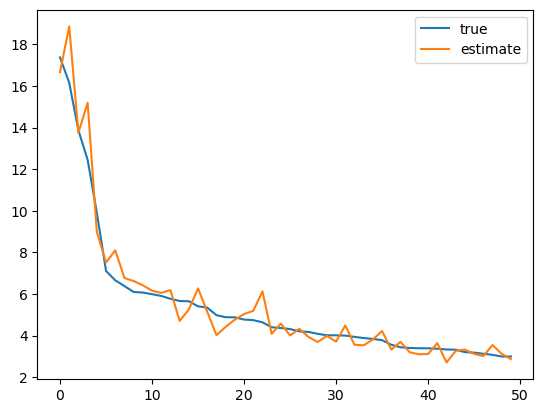

In [360]:
import matplotlib.pyplot as plt


# Sort the true_list in descending order
combined_lists = zip(true_dr, sample_density_ratio2)

# Sort the combined_lists based on the values of true_lst
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0],reverse=True)

# Separate the sorted lists back into true_lst and other_lst
sorted_true, sorted_estimate = zip(*sorted_combined_lists)

# Generate x-axis values
x_start =0
x_end = 50
x = range(x_end - x_start)

# Calculate the difference between the true and estimate lists
difference = [true - estimate for true, estimate in zip(sorted_true, sorted_estimate)]
print(la.norm(difference)**2/5000)
# plt.plot(x, true_list[x_start:x_end], label='true')
# plt.plot(x, sample_density_ratio2[x_start:x_end], label='estimate')
plt.plot(x, sorted_true[x_start:x_end], label='true')
plt.plot(x, sorted_estimate[x_start:x_end], label='estimate')
plt.legend()
plt.show()

In [61]:
# Calculate average loss of 2 estimate method
for i in range(1000):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)



KeyboardInterrupt: 

In [311]:
s = np.array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])
t = np.array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])
u = np.array([ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

## Simulation study

In [33]:
# verificaion by the p value
l = 3
count = 0
#calculate covariance matrix
probability= 0
for j in trange(200):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 1, Alpha_t = 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    # densratio_obj = densratio(D_t, D_s)
    # #calculate density ratio for each sample
    # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)
    true_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 1, Alpha_t = 0)
    est_dr = v_dr[:2000] * xz_dr[:2000]

    # cov1 = generate_cov_matrix(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)
    # # print(cov1)
    # w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
    # weight = la.eigh(cov1)[0]
    # print([w,statistic])
    # p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
    # #p_value = monte_carlo_p_value(100000, cov1, l, statistic)
    w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
    p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
    probability = count/(j+1)


  0%|          | 1/200 [00:01<05:32,  1.67s/it]

0.00018999743232006594


  1%|          | 2/200 [00:03<05:10,  1.57s/it]

2.732401094274195e-08


  2%|▏         | 3/200 [00:04<04:55,  1.50s/it]

0.0022916114933878573


  2%|▏         | 4/200 [00:05<04:46,  1.46s/it]

2.2921965683320167e-06


  2%|▎         | 5/200 [00:07<04:43,  1.45s/it]

4.8231414311650234e-05


  3%|▎         | 6/200 [00:08<04:38,  1.43s/it]

2.005734961563199e-06


  4%|▎         | 7/200 [00:10<04:36,  1.43s/it]

0.002354327864749428


  4%|▍         | 8/200 [00:11<04:39,  1.46s/it]

2.744257531217542e-06


  4%|▍         | 9/200 [00:13<04:35,  1.44s/it]

4.896867186188203e-07


  5%|▌         | 10/200 [00:14<04:31,  1.43s/it]

0.00027479093109450403


  6%|▌         | 11/200 [00:15<04:28,  1.42s/it]

5.739806304894124e-05


  6%|▌         | 12/200 [00:17<04:26,  1.42s/it]

2.5464003794439805e-08


  6%|▋         | 13/200 [00:18<04:26,  1.43s/it]

2.4375917347940756e-06


  7%|▋         | 14/200 [00:20<04:23,  1.42s/it]

3.5516968136528604e-05


  8%|▊         | 15/200 [00:21<04:21,  1.42s/it]

3.921976167164942e-07


  8%|▊         | 16/200 [00:23<04:19,  1.41s/it]

0.0014655861707287832


  8%|▊         | 17/200 [00:24<04:18,  1.41s/it]

7.308299045494238e-06


  9%|▉         | 18/200 [00:25<04:16,  1.41s/it]

9.416142135709737e-05


 10%|▉         | 19/200 [00:27<04:14,  1.41s/it]

0.008324935424188107


 10%|█         | 20/200 [00:28<04:13,  1.41s/it]

3.940000081747996e-08


 10%|█         | 20/200 [00:29<04:24,  1.47s/it]


KeyboardInterrupt: 

In [27]:
# Power enhancement
l = 5
count = 0
#calculate covariance matrix
probability= 0
for j in trange(200):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    reg=1
    
    true_dr = true_density_ratio(X_source[:2000], Z_source[:2000], V_source[:2000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    est_dr = v_dr[:2000] * xz_dr[:2000]
    
    WV, statistic, a, b, c, g = PCRtest_Powen(Y_source[:2000], X_source[:2000], Z_source[:2000], V_source[:2000], Y_target[:2000], X_target[:2000], Z_target[:2000], V_target[:2000], u, s, t, l, 20, true_dr, reg)
    cov = generate_cov_matrix_powen(a, b, c, g, l, 20, density_ratio = true_dr)
    weight = la.eigh(cov)[0]
    p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
    print(p_value)

    if p_value < 0.1:
        count += 1
    probability = count/(j+1)

  0%|          | 1/200 [00:04<14:18,  4.32s/it]

0.01612985856628457


  1%|          | 2/200 [00:08<14:09,  4.29s/it]

0.00017110323746560852


  2%|▏         | 3/200 [00:12<14:08,  4.31s/it]

1.6415635431088482e-05


  2%|▏         | 4/200 [00:17<14:10,  4.34s/it]

0.03732714269572346


  2%|▎         | 5/200 [00:21<14:06,  4.34s/it]

1.2202567756247618e-07


  3%|▎         | 6/200 [00:25<14:00,  4.33s/it]

0.010494790711144342


  4%|▎         | 7/200 [00:30<13:49,  4.30s/it]

0.266489794419144


  4%|▍         | 8/200 [00:34<13:47,  4.31s/it]

0.5853667133722258


  4%|▍         | 9/200 [00:38<13:42,  4.30s/it]

0.025496497621961378


  5%|▌         | 10/200 [00:43<13:40,  4.32s/it]

1.1128771237878254e-09


  6%|▌         | 11/200 [00:47<13:32,  4.30s/it]

0.0019244439437492433


  6%|▌         | 12/200 [00:51<13:28,  4.30s/it]

0.038430806682498986


  6%|▋         | 13/200 [00:55<13:21,  4.28s/it]

0.00037099251994621163


  7%|▋         | 14/200 [01:00<13:18,  4.29s/it]

0.2611410426748193


  8%|▊         | 15/200 [01:04<13:14,  4.29s/it]

0.289440492899824


  8%|▊         | 16/200 [01:08<13:04,  4.26s/it]

0.46845767838378916


  8%|▊         | 17/200 [01:13<13:00,  4.27s/it]

0.7310305404475037


  9%|▉         | 18/200 [01:17<12:57,  4.27s/it]

0.23417449910574373


 10%|▉         | 19/200 [01:21<12:49,  4.25s/it]

0.3909351583091142


 10%|█         | 20/200 [01:25<12:45,  4.25s/it]

0.00022738606041150522


 10%|█         | 21/200 [01:29<12:37,  4.23s/it]

0.03473552416261905


 11%|█         | 22/200 [01:34<12:36,  4.25s/it]

0.016589606037921034


 12%|█▏        | 23/200 [01:38<12:33,  4.26s/it]

0.0027846327502402124


 12%|█▏        | 24/200 [01:42<12:25,  4.23s/it]

0.00015914674467587542


 12%|█▎        | 25/200 [01:47<12:27,  4.27s/it]

0.15813494895917002


 13%|█▎        | 26/200 [01:51<12:21,  4.26s/it]

0.03390060695889807


 14%|█▎        | 27/200 [01:55<12:18,  4.27s/it]

0.41492390347032804


 14%|█▍        | 28/200 [01:59<12:15,  4.28s/it]

0.0342360320458488


 14%|█▍        | 29/200 [02:04<12:10,  4.27s/it]

0.30924678242159664


 15%|█▌        | 30/200 [02:08<12:03,  4.26s/it]

0.05640831458370732


 16%|█▌        | 31/200 [02:12<11:58,  4.25s/it]

6.015327540076498e-06


 16%|█▌        | 32/200 [02:16<11:57,  4.27s/it]

0.06360429432456327


 16%|█▋        | 33/200 [02:21<11:52,  4.27s/it]

0.021403159391347626


 17%|█▋        | 34/200 [02:25<11:48,  4.27s/it]

0.06574214524224364


 18%|█▊        | 35/200 [02:29<11:44,  4.27s/it]

0.19923789383317747


 18%|█▊        | 36/200 [02:34<11:41,  4.28s/it]

0.09986108221104906


 18%|█▊        | 37/200 [02:38<11:37,  4.28s/it]

0.000301557220502513


 19%|█▉        | 38/200 [02:42<11:33,  4.28s/it]

0.0003936531549276756


 20%|█▉        | 39/200 [02:46<11:31,  4.30s/it]

6.733042972384418e-06


 20%|██        | 40/200 [02:51<11:26,  4.29s/it]

0.0019275258989864819


 20%|██        | 41/200 [02:55<11:17,  4.26s/it]

0.02829013210687381


 21%|██        | 42/200 [02:59<11:13,  4.26s/it]

2.6988347352485675e-06


 22%|██▏       | 43/200 [03:03<11:05,  4.24s/it]

0.012981769852767111


 22%|██▏       | 44/200 [03:08<11:07,  4.28s/it]

9.01691805421656e-06


 22%|██▎       | 45/200 [03:12<11:01,  4.27s/it]

0.0005870942499720533


 23%|██▎       | 46/200 [03:16<10:53,  4.25s/it]

0.10546778647240118


 24%|██▎       | 47/200 [03:20<10:48,  4.24s/it]

0.03004955511455798


 24%|██▍       | 48/200 [03:25<10:47,  4.26s/it]

7.009330557639082e-06


 24%|██▍       | 49/200 [03:29<10:38,  4.23s/it]

0.15062183673184404


 25%|██▌       | 50/200 [03:33<10:32,  4.21s/it]

0.10592554290775058


 26%|██▌       | 51/200 [03:37<10:31,  4.24s/it]

0.22080416688011062


 26%|██▌       | 52/200 [03:42<10:27,  4.24s/it]

0.0007498042694711327


 26%|██▋       | 53/200 [03:46<10:26,  4.26s/it]

0.006868089424333035


 27%|██▋       | 54/200 [03:50<10:23,  4.27s/it]

0.060592736496563604


 28%|██▊       | 55/200 [03:54<10:17,  4.26s/it]

2.8006847492267894e-06


 28%|██▊       | 56/200 [03:59<10:10,  4.24s/it]

0.04293258786744736


 28%|██▊       | 57/200 [04:03<10:05,  4.23s/it]

0.0035748303185586527


 29%|██▉       | 58/200 [04:07<10:03,  4.25s/it]

0.00023480279363896628


 30%|██▉       | 59/200 [04:11<10:02,  4.27s/it]

5.293013027873883e-08


 30%|███       | 60/200 [04:16<09:54,  4.25s/it]

0.00012062808377799605


 30%|███       | 61/200 [04:20<09:50,  4.25s/it]

0.00032932715111599897


 31%|███       | 62/200 [04:24<09:47,  4.26s/it]

5.0240056559403e-10


 32%|███▏      | 63/200 [04:28<09:44,  4.27s/it]

0.004957468380039742


 32%|███▏      | 64/200 [04:33<09:40,  4.27s/it]

0.3397428257050048


 32%|███▎      | 65/200 [04:37<09:37,  4.28s/it]

0.011561520265675695


 33%|███▎      | 66/200 [04:42<09:43,  4.35s/it]

0.11464386321904563


 34%|███▎      | 67/200 [04:46<09:39,  4.36s/it]

0.7968502093028718


 34%|███▍      | 68/200 [04:50<09:35,  4.36s/it]

0.36725192356845304


 34%|███▍      | 69/200 [04:55<09:25,  4.32s/it]

0.0009465496163892917


 35%|███▌      | 70/200 [04:59<09:20,  4.31s/it]

0.00020892464328337024


 36%|███▌      | 71/200 [05:03<09:16,  4.32s/it]

3.380784578954632e-07


 36%|███▌      | 72/200 [05:07<09:12,  4.32s/it]

0.012111027702128574


 36%|███▋      | 73/200 [05:12<09:06,  4.30s/it]

0.00194134344208019


 37%|███▋      | 74/200 [05:16<09:07,  4.34s/it]

0.06703747824348893


 38%|███▊      | 75/200 [05:20<09:02,  4.34s/it]

0.00010950712270940688


 38%|███▊      | 76/200 [05:25<08:55,  4.32s/it]

0.22970182886813262


 38%|███▊      | 77/200 [05:29<08:53,  4.34s/it]

0.22812341741494602


 39%|███▉      | 78/200 [05:33<08:48,  4.33s/it]

0.010092056841911168


 40%|███▉      | 79/200 [05:38<08:44,  4.34s/it]

0.0017150334764597375


 40%|████      | 80/200 [05:42<08:37,  4.31s/it]

0.0015719774486816496


 40%|████      | 81/200 [05:46<08:31,  4.30s/it]

0.06429087115259735


 41%|████      | 82/200 [05:51<08:26,  4.29s/it]

1.0664721616926442e-06


 42%|████▏     | 83/200 [05:55<08:19,  4.27s/it]

0.47780701455469177


 42%|████▏     | 84/200 [05:59<08:15,  4.27s/it]

0.24054882229396535


 42%|████▎     | 85/200 [06:03<08:10,  4.26s/it]

0.017857271911815742


 43%|████▎     | 86/200 [06:08<08:02,  4.24s/it]

0.41956060581063215


 44%|████▎     | 87/200 [06:12<07:56,  4.22s/it]

0.0003252522757986043


 44%|████▍     | 88/200 [06:16<07:53,  4.22s/it]

8.470871714960637e-06


 44%|████▍     | 89/200 [06:20<07:56,  4.29s/it]

0.2417769439234575


 45%|████▌     | 90/200 [06:25<07:51,  4.29s/it]

0.6629169925268615


 46%|████▌     | 91/200 [06:29<07:51,  4.32s/it]

4.036092779102773e-06


 46%|████▌     | 92/200 [06:34<07:51,  4.36s/it]

0.018791676693148296


 46%|████▋     | 93/200 [06:38<07:47,  4.37s/it]

0.009840600075340378


 47%|████▋     | 94/200 [06:42<07:42,  4.36s/it]

0.04066261136029026


 48%|████▊     | 95/200 [06:47<07:37,  4.35s/it]

0.0006981030416721712


 48%|████▊     | 96/200 [06:51<07:32,  4.35s/it]

0.40696281499127906


 48%|████▊     | 97/200 [06:55<07:22,  4.30s/it]

0.0007566619288560394


 49%|████▉     | 98/200 [07:00<07:22,  4.34s/it]

0.18787563042701572


 50%|████▉     | 99/200 [07:04<07:20,  4.36s/it]

0.02892824093728874


 50%|█████     | 100/200 [07:08<07:14,  4.34s/it]

4.324486846285502e-06


 50%|█████     | 101/200 [07:12<07:06,  4.31s/it]

0.06459993647696505


 51%|█████     | 102/200 [07:17<06:59,  4.29s/it]

6.499720187536084e-05


 52%|█████▏    | 103/200 [07:21<06:53,  4.27s/it]

0.001059764640133909


 52%|█████▏    | 104/200 [07:25<06:48,  4.26s/it]

0.00022655685971628703


 52%|█████▎    | 105/200 [07:30<06:46,  4.28s/it]

6.5576851911997025e-06


 53%|█████▎    | 106/200 [07:34<06:40,  4.26s/it]

0.007967898639938187


 54%|█████▎    | 107/200 [07:38<06:39,  4.30s/it]

0.0031287439953773255


 54%|█████▍    | 108/200 [07:42<06:32,  4.27s/it]

0.0004132560458482981


 55%|█████▍    | 109/200 [07:47<06:31,  4.31s/it]

0.0020237721612481607


 55%|█████▌    | 110/200 [07:51<06:23,  4.27s/it]

0.22390968259740385


 56%|█████▌    | 111/200 [07:55<06:18,  4.25s/it]

0.46594182732571165


 56%|█████▌    | 112/200 [07:59<06:15,  4.27s/it]

0.0010191771685638118


 56%|█████▋    | 113/200 [08:04<06:11,  4.27s/it]

0.09187214987445158


 57%|█████▋    | 114/200 [08:08<06:06,  4.26s/it]

0.00019563167726499575


 57%|█████▊    | 115/200 [08:12<06:02,  4.26s/it]

0.0036342814089067588


 58%|█████▊    | 116/200 [08:16<05:56,  4.24s/it]

0.10121047710326592


 58%|█████▊    | 117/200 [08:21<05:53,  4.26s/it]

5.7999194114088937e-08


 59%|█████▉    | 118/200 [08:25<05:51,  4.29s/it]

0.04184799313684018


 60%|█████▉    | 119/200 [08:30<05:55,  4.39s/it]

0.0009845561347232579


 60%|██████    | 120/200 [08:34<05:48,  4.36s/it]

0.0002801369666619591


 60%|██████    | 121/200 [08:38<05:46,  4.39s/it]

0.04214999563248756


 61%|██████    | 122/200 [08:43<05:42,  4.40s/it]

0.08123643819621884


 62%|██████▏   | 123/200 [08:47<05:33,  4.34s/it]

0.3248285348792471


 62%|██████▏   | 124/200 [08:51<05:29,  4.34s/it]

9.469939864326093e-05


 62%|██████▎   | 125/200 [08:56<05:23,  4.31s/it]

0.14506060410919497


 63%|██████▎   | 126/200 [09:00<05:17,  4.29s/it]

0.06082583213195514


 64%|██████▎   | 127/200 [09:04<05:14,  4.30s/it]

0.2207791898394491


 64%|██████▍   | 128/200 [09:09<05:13,  4.35s/it]

0.31840391670281787


 64%|██████▍   | 129/200 [09:13<05:05,  4.30s/it]

0.09215557402764962


 65%|██████▌   | 130/200 [09:17<05:00,  4.30s/it]

0.74002230261072


 66%|██████▌   | 131/200 [09:21<04:55,  4.29s/it]

5.474145642714312e-05


 66%|██████▌   | 132/200 [09:26<04:48,  4.25s/it]

0.00028766637142418894


 66%|██████▋   | 133/200 [09:30<04:50,  4.33s/it]

0.7426433977932313


 67%|██████▋   | 134/200 [09:34<04:45,  4.32s/it]

0.02486664941012451


 68%|██████▊   | 135/200 [09:39<04:42,  4.34s/it]

0.0005286124970013129


 68%|██████▊   | 136/200 [09:43<04:37,  4.33s/it]

0.00695743955163608


 68%|██████▊   | 137/200 [09:47<04:33,  4.34s/it]

0.011612319237388258


 69%|██████▉   | 138/200 [09:52<04:27,  4.31s/it]

2.398570364547936e-08


 70%|██████▉   | 139/200 [09:56<04:22,  4.30s/it]

0.0031042390374503848


 70%|███████   | 140/200 [10:00<04:18,  4.30s/it]

0.006380264883440234


 70%|███████   | 141/200 [10:05<04:16,  4.34s/it]

0.008866534033643125


 71%|███████   | 142/200 [10:09<04:10,  4.32s/it]

0.03495083848682934


 72%|███████▏  | 143/200 [10:13<04:04,  4.29s/it]

0.0036723455136730143


 72%|███████▏  | 144/200 [10:17<04:01,  4.31s/it]

0.00015344147661522367


 72%|███████▎  | 145/200 [10:22<03:55,  4.28s/it]

6.925810205704597e-05


 73%|███████▎  | 146/200 [10:26<03:51,  4.29s/it]

0.23613799974005978


 74%|███████▎  | 147/200 [10:30<03:49,  4.32s/it]

0.0005343304682976502


 74%|███████▍  | 148/200 [10:35<03:45,  4.34s/it]

0.2710313209361698


 74%|███████▍  | 149/200 [10:39<03:40,  4.33s/it]

0.014530927146516381


 75%|███████▌  | 150/200 [10:43<03:34,  4.29s/it]

0.19112888026362995


 76%|███████▌  | 151/200 [10:47<03:28,  4.26s/it]

0.1749926317223105


 76%|███████▌  | 152/200 [10:52<03:23,  4.23s/it]

0.007138060933290724


 76%|███████▋  | 153/200 [10:56<03:17,  4.20s/it]

0.6408767115033491


 77%|███████▋  | 154/200 [11:00<03:12,  4.18s/it]

1.1592006212146622e-05


 78%|███████▊  | 155/200 [11:04<03:07,  4.16s/it]

0.0020436550389959507


 78%|███████▊  | 156/200 [11:08<03:03,  4.17s/it]

0.2883899037973655


 78%|███████▊  | 157/200 [11:12<02:58,  4.15s/it]

0.010964120596617999


 79%|███████▉  | 158/200 [11:16<02:54,  4.15s/it]

0.00021342173558758226


 80%|███████▉  | 159/200 [11:21<02:50,  4.15s/it]

0.29972030469550537


 80%|████████  | 160/200 [11:25<02:46,  4.16s/it]

3.803266157542673e-05


 80%|████████  | 161/200 [11:29<02:41,  4.14s/it]

0.0006746166069885318


 81%|████████  | 162/200 [11:33<02:36,  4.13s/it]

0.001192460503478654


 82%|████████▏ | 163/200 [11:37<02:33,  4.14s/it]

0.2454633150633374


 82%|████████▏ | 164/200 [11:41<02:29,  4.14s/it]

0.002164224268266346


 82%|████████▎ | 165/200 [11:45<02:25,  4.15s/it]

0.013168767826127192


 83%|████████▎ | 166/200 [11:50<02:20,  4.14s/it]

0.0002716177145852816


 84%|████████▎ | 167/200 [11:54<02:16,  4.14s/it]

0.005278216416427228


 84%|████████▍ | 168/200 [11:58<02:12,  4.14s/it]

0.001986697899704404


 84%|████████▍ | 169/200 [12:02<02:08,  4.14s/it]

5.209335525835357e-06


 85%|████████▌ | 170/200 [12:06<02:03,  4.13s/it]

0.7824557887042309


 86%|████████▌ | 171/200 [12:10<02:00,  4.14s/it]

0.000168944833629614


 86%|████████▌ | 172/200 [12:14<01:55,  4.14s/it]

0.0013207014139425821


 86%|████████▋ | 173/200 [12:19<01:51,  4.14s/it]

0.0021396704913487774


 87%|████████▋ | 174/200 [12:23<01:47,  4.13s/it]

0.08459509397599829


 88%|████████▊ | 175/200 [12:27<01:43,  4.15s/it]

3.931893860520397e-05


 88%|████████▊ | 176/200 [12:31<01:39,  4.15s/it]

2.2002567345857926e-07


 88%|████████▊ | 177/200 [12:35<01:35,  4.15s/it]

0.00025033532848084405


 89%|████████▉ | 178/200 [12:39<01:31,  4.14s/it]

0.0005408503588753


 90%|████████▉ | 179/200 [12:43<01:27,  4.15s/it]

5.3417637302377585e-06


 90%|█████████ | 180/200 [12:48<01:22,  4.14s/it]

5.0135973886700214e-05


 90%|█████████ | 181/200 [12:52<01:18,  4.14s/it]

9.850442030157058e-05


 91%|█████████ | 182/200 [12:56<01:14,  4.13s/it]

0.03878099567748872


 92%|█████████▏| 183/200 [13:00<01:10,  4.17s/it]

3.0350248103605537e-06


 92%|█████████▏| 184/200 [13:04<01:06,  4.17s/it]

2.2824761469197874e-05


 92%|█████████▎| 185/200 [13:08<01:02,  4.16s/it]

0.0003567649533202655


 93%|█████████▎| 186/200 [13:13<00:58,  4.16s/it]

0.000858774274196672


 94%|█████████▎| 187/200 [13:17<00:54,  4.16s/it]

0.001737131760028876


 94%|█████████▍| 188/200 [13:21<00:49,  4.15s/it]

0.00043680121142630757


 94%|█████████▍| 189/200 [13:25<00:45,  4.15s/it]

0.0006024734211712568


 95%|█████████▌| 190/200 [13:29<00:41,  4.16s/it]

0.0075923194435346675


 96%|█████████▌| 191/200 [13:33<00:37,  4.16s/it]

0.009425926148228458


 96%|█████████▌| 192/200 [13:38<00:33,  4.18s/it]

0.0008155793189974503


 96%|█████████▋| 193/200 [13:42<00:29,  4.17s/it]

0.009631634050868199


 97%|█████████▋| 194/200 [13:46<00:25,  4.17s/it]

0.06068013716251952


 98%|█████████▊| 195/200 [13:50<00:20,  4.16s/it]

0.3150136326283637


 98%|█████████▊| 196/200 [13:54<00:16,  4.15s/it]

0.061741341536992955


 98%|█████████▊| 197/200 [13:58<00:12,  4.15s/it]

0.012796335803043402


 99%|█████████▉| 198/200 [14:02<00:08,  4.15s/it]

4.428169933845538e-06


100%|█████████▉| 199/200 [14:07<00:04,  4.16s/it]

0.1387114059566812


100%|██████████| 200/200 [14:11<00:00,  4.26s/it]

0.00033912844483974247


### Benchmark for no covariate shift

In [35]:
# verificaion by the p value
prob_lst = []
for l in [2,5,10,15,20,30]:

    count = 0
    #calculate covariance matrix
    probability= 0
    for j in trange(200):
        #generate data
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 1, Alpha_t = 0)

        # calculate density ratio
        D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
        D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

        v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
        xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
        # densratio_obj = densratio(D_t, D_s)
        # #calculate density ratio for each sample
        # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)
        true_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 1, Alpha_t = 0)
        est_dr = v_dr[:2000] * xz_dr[:2000]

        # cov1 = generate_cov_matrix(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)
        # # print(cov1)
        # w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
        # weight = la.eigh(cov1)[0]
        # print([w,statistic])
        # p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
        # #p_value = monte_carlo_p_value(100000, cov1, l, statistic)
        w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
        p_value = chi_squared_p_value(statistic, l-1)
        #print(p_value)
        if p_value < 0.1:
            count += 1
        probability = count/(j+1)
    prob_lst.append(probability)

100%|██████████| 200/200 [24:14<00:00,  7.27s/it]


### Benchmark method: Resampling from source


In [48]:
def resample(Y_source, X_source, Z_source, V_source, M, density_ratio = None):
    n = Y_source.shape[0]
    Y_, X_, Z_, V_ = [], [], [], []
    for i in range(n):
        value = density_ratio[i]
        u = np.random.random()
        if value >= u * M:
            Y_.append(Y_source[i])
            X_.append(X_source[i])
            Z_.append(Z_source[i])
            V_.append(V_source[i])
    Y_, X_, Z_, V_ = np.array(Y_) , np.array(X_), np.array(Z_), np.array(V_)
    return Y_, X_, Z_, V_


def benchmark(test_n, alpha, L, K):
    sample_density_ratio2=1
    count = 0
    beta = 0.2
    chi_list_1=[3.841, 5.991, 7.815, 9.488, 11.07]
    chi_list_2=[2.706, 4.605, 6.251, 7.779, 9.236]
    p_list=[]
    sample_num=[]
    eff_size=[]
    Las = LassoCV()
    for i in trange(test_n):
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, alpha, beta)
        W = np.hstack((X_source, Z_source))
        reg = Las.fit(W, Y_source.ravel())

        Y_, X_, Z_, V_ , size = resample(Y_source, X_source, Z_source, V_source, Y_target, X_target, V_target, Z_target)
        xp, p_value = PCRtest(Y_, X_, Z_, V_, u, s, t, L, K, covariate_shift = False, density_ratio = 1, regr = reg)
        #print(xp)
        if p_value > chi_list_1[L-2]:
            count += 1
        p_list.append(p_value)
        sample_num.append(Y_.size)
        eff_size.append(size)

    print("count = ", count, "score =",  count/test_n)
    print(p_list)
    #print(sample_num)
    #print(np.array(eff_size)*np.array(sample_num))
    return count, count/test_n

l = 20

count = 0

for i in trange(200):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2)
    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    true_dr = true_density_ratio(X_source[:5000], Z_source[:5000], V_source[:5000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    Max = np.max(true_dr)
    Min = np.min(true_dr)

    
    # sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)

    reg = 1
    Y_, X_, Z_, V_ = resample(Y_source[:5000], X_source[:5000], Z_source[:5000], V_source[:5000], M =Max, density_ratio=true_dr)
    _,statistic = PCRtest(Y_, X_, Z_, V_, u, s, t, L = l, K = 20, covariate_shift = False, density_ratio = None, regr = reg)
    p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
probability = count/200

  0%|          | 1/200 [00:01<03:32,  1.07s/it]

0.560857539478349


  1%|          | 2/200 [00:02<04:15,  1.29s/it]

0.6731001328713992


  2%|▏         | 3/200 [00:03<03:57,  1.21s/it]

0.6534980322018933


  2%|▏         | 4/200 [00:04<03:47,  1.16s/it]

0.37757323433796364


  2%|▎         | 5/200 [00:05<03:41,  1.14s/it]

0.39457818208600104


  3%|▎         | 6/200 [00:06<03:37,  1.12s/it]

0.7724764198392838


  4%|▎         | 7/200 [00:07<03:32,  1.10s/it]

0.09005700862500488


  4%|▍         | 8/200 [00:08<03:26,  1.08s/it]

0.17180928940610396


  4%|▍         | 9/200 [00:10<03:28,  1.09s/it]

0.976990835143052


  5%|▌         | 10/200 [00:11<03:24,  1.08s/it]

0.4270431701286901


  6%|▌         | 11/200 [00:12<03:24,  1.08s/it]

0.8856253321541485


  6%|▌         | 12/200 [00:13<03:28,  1.11s/it]

0.6572779982006439


  6%|▋         | 13/200 [00:14<03:25,  1.10s/it]

0.971030647582209


  7%|▋         | 14/200 [00:15<03:23,  1.09s/it]

0.30984187676161834


  8%|▊         | 15/200 [00:16<03:33,  1.16s/it]

0.3840302785619858


  8%|▊         | 16/200 [00:18<03:36,  1.18s/it]

0.0890836297419636


  8%|▊         | 17/200 [00:19<03:38,  1.20s/it]

0.727953069581455


  9%|▉         | 18/200 [00:20<03:46,  1.24s/it]

0.38067708549740575


 10%|▉         | 19/200 [00:21<03:40,  1.22s/it]

0.034652057391800106


 10%|█         | 20/200 [00:22<03:34,  1.19s/it]

0.9099731258608494


 10%|█         | 21/200 [00:24<03:26,  1.15s/it]

0.6237011610039871


 11%|█         | 22/200 [00:25<03:29,  1.18s/it]

0.14790387263098626


 12%|█▏        | 23/200 [00:26<03:29,  1.18s/it]

0.041164315772245996


 12%|█▏        | 24/200 [00:27<03:21,  1.15s/it]

0.40805995854747246


 12%|█▎        | 25/200 [00:28<03:19,  1.14s/it]

0.1797453915484698


 13%|█▎        | 26/200 [00:29<03:21,  1.16s/it]

0.47383101231782243


 14%|█▎        | 27/200 [00:30<03:17,  1.14s/it]

0.560857539478349


 14%|█▍        | 28/200 [00:32<03:16,  1.14s/it]

0.03190382525838964


 14%|█▍        | 29/200 [00:33<03:10,  1.11s/it]

0.47529778767402064


 15%|█▌        | 30/200 [00:34<03:07,  1.10s/it]

0.6390109233742953


 16%|█▌        | 31/200 [00:35<03:13,  1.14s/it]

0.03837827249823966


 16%|█▌        | 32/200 [00:36<03:10,  1.13s/it]

0.43564773769699183


 16%|█▋        | 33/200 [00:37<03:07,  1.12s/it]

0.05682856761240118


 17%|█▋        | 34/200 [00:38<03:09,  1.14s/it]

0.3408580231778938


 18%|█▊        | 35/200 [00:39<03:02,  1.11s/it]

0.45683612559196274


 18%|█▊        | 36/200 [00:40<02:59,  1.10s/it]

0.9048632837370207


 18%|█▊        | 37/200 [00:42<03:00,  1.11s/it]

0.5898678221289586


 19%|█▉        | 38/200 [00:43<02:59,  1.11s/it]

0.4658198245754862


 20%|█▉        | 39/200 [00:44<03:01,  1.12s/it]

0.2842562586689543


 20%|██        | 40/200 [00:45<02:56,  1.10s/it]

0.3186781207255982


 20%|██        | 41/200 [00:46<02:53,  1.09s/it]

0.5002854481266428


 21%|██        | 42/200 [00:47<02:49,  1.08s/it]

0.6939621062657546


 22%|██▏       | 43/200 [00:48<02:50,  1.09s/it]

0.002681896628511926


 22%|██▏       | 44/200 [00:49<02:56,  1.13s/it]

0.010594346529662402


 22%|██▎       | 45/200 [00:50<02:55,  1.13s/it]

0.5129153573092655


 23%|██▎       | 46/200 [00:52<02:57,  1.15s/it]

0.46659409747453817


 24%|██▎       | 47/200 [00:53<02:52,  1.13s/it]

0.042265931559537395


 24%|██▍       | 48/200 [00:54<03:02,  1.20s/it]

0.0874120056394807


 24%|██▍       | 49/200 [00:55<02:56,  1.17s/it]

0.08342862398216522


 25%|██▌       | 50/200 [00:56<02:52,  1.15s/it]

0.18776585153824865


 26%|██▌       | 51/200 [00:57<02:50,  1.14s/it]

0.4568361255919626


 26%|██▌       | 52/200 [00:59<02:47,  1.13s/it]

0.6381379338097123


 26%|██▋       | 53/200 [01:00<02:49,  1.15s/it]

0.2523429546714817


 27%|██▋       | 54/200 [01:01<02:52,  1.18s/it]

0.320727467806475


 28%|██▊       | 55/200 [01:02<02:45,  1.14s/it]

0.8856253321541485


 28%|██▊       | 56/200 [01:03<02:43,  1.13s/it]

0.6418295962978486


 28%|██▊       | 57/200 [01:04<02:47,  1.17s/it]

0.11684948016509478


 29%|██▉       | 58/200 [01:06<02:45,  1.17s/it]

0.34583000232232297


 30%|██▉       | 59/200 [01:07<02:42,  1.15s/it]

0.8328346934669643


 30%|███       | 60/200 [01:08<02:38,  1.13s/it]

0.5224382739862625


 30%|███       | 61/200 [01:09<02:42,  1.17s/it]

0.6092174000663165


 31%|███       | 62/200 [01:10<02:38,  1.15s/it]

0.4836546261446629


 32%|███▏      | 63/200 [01:11<02:35,  1.14s/it]

0.47529778767402064


 32%|███▏      | 64/200 [01:12<02:32,  1.12s/it]

0.08342862398216522


 32%|███▎      | 65/200 [01:14<02:32,  1.13s/it]

0.7316327550215096


 33%|███▎      | 66/200 [01:15<02:38,  1.18s/it]

0.4964583590368862


 34%|███▎      | 67/200 [01:16<02:34,  1.16s/it]

0.007206720406512712


 34%|███▍      | 68/200 [01:17<02:29,  1.13s/it]

0.6237011610039871


 34%|███▍      | 69/200 [01:18<02:29,  1.14s/it]

0.17180928940610396


 35%|███▌      | 70/200 [01:19<02:31,  1.16s/it]

0.6867823249549851


 36%|███▌      | 71/200 [01:20<02:24,  1.12s/it]

0.5224382739862625


 36%|███▌      | 72/200 [01:22<02:24,  1.13s/it]

0.018377641939263945


 36%|███▋      | 73/200 [01:23<02:23,  1.13s/it]

0.08774520144692921


 37%|███▋      | 74/200 [01:24<02:21,  1.13s/it]

0.9048632837370207


 38%|███▊      | 75/200 [01:25<02:26,  1.18s/it]

0.19788590532151396


 38%|███▊      | 76/200 [01:26<02:25,  1.17s/it]

0.6451144966202325


 38%|███▊      | 77/200 [01:27<02:23,  1.16s/it]

0.33680090192753354


 39%|███▉      | 78/200 [01:28<02:17,  1.13s/it]

0.560857539478349


 40%|███▉      | 79/200 [01:30<02:16,  1.12s/it]

0.07753688413641724


 40%|████      | 80/200 [01:31<02:14,  1.12s/it]

0.7639244192506934


 40%|████      | 81/200 [01:32<02:16,  1.15s/it]

0.5296702377829468


 41%|████      | 82/200 [01:33<02:11,  1.12s/it]

0.018377641939263945


 42%|████▏     | 83/200 [01:34<02:12,  1.13s/it]

0.9947826210111743


 42%|████▏     | 84/200 [01:35<02:16,  1.18s/it]

0.06162182328315169


 42%|████▎     | 85/200 [01:36<02:12,  1.15s/it]

0.29312679232975014


 43%|████▎     | 86/200 [01:38<02:10,  1.14s/it]

0.0442377886890144


 44%|████▎     | 87/200 [01:39<02:13,  1.18s/it]

0.9299505441684552


 44%|████▍     | 88/200 [01:40<02:10,  1.16s/it]

0.4817467090422528


 44%|████▍     | 89/200 [01:41<02:11,  1.18s/it]

0.3186781207255982


 45%|████▌     | 90/200 [01:42<02:07,  1.15s/it]

0.43864987415822654


 46%|████▌     | 91/200 [01:44<02:10,  1.20s/it]

0.06034654952976648


 46%|████▌     | 92/200 [01:45<02:05,  1.17s/it]

0.7155096746941277


 46%|████▋     | 93/200 [01:46<02:02,  1.15s/it]

0.3179037343190805


 47%|████▋     | 94/200 [01:47<02:01,  1.14s/it]

0.7323240297841109


 48%|████▊     | 95/200 [01:48<01:59,  1.13s/it]

0.2523429546714817


 48%|████▊     | 96/200 [01:49<01:57,  1.13s/it]

0.7836913118130485


 48%|████▊     | 97/200 [01:50<01:58,  1.16s/it]

0.5672963794276287


 49%|████▉     | 98/200 [01:51<01:54,  1.13s/it]

0.5224382739862625


 50%|████▉     | 99/200 [01:53<01:53,  1.12s/it]

0.25404916785428533


 50%|█████     | 100/200 [01:54<01:49,  1.10s/it]

0.2655347136160342


 50%|█████     | 101/200 [01:55<01:51,  1.13s/it]

0.5354840990472814


 51%|█████     | 102/200 [01:56<01:51,  1.14s/it]

0.03596764728359081


 52%|█████▏    | 103/200 [01:57<01:48,  1.12s/it]

0.7374302402375386


 52%|█████▏    | 104/200 [01:58<01:47,  1.12s/it]

0.07240899781292409


 52%|█████▎    | 105/200 [01:59<01:46,  1.12s/it]

0.18367527251377358


 53%|█████▎    | 106/200 [02:00<01:44,  1.11s/it]

0.4270431701286901


 54%|█████▎    | 107/200 [02:01<01:44,  1.13s/it]

0.4685545779016568


 54%|█████▍    | 108/200 [02:03<01:41,  1.11s/it]

0.047706497053595864


 55%|█████▍    | 109/200 [02:04<01:40,  1.11s/it]

0.9238384459825877


 55%|█████▌    | 110/200 [02:05<01:41,  1.13s/it]

0.5866416267889036


 56%|█████▌    | 111/200 [02:06<01:38,  1.11s/it]

0.06956187048195439


 56%|█████▌    | 112/200 [02:07<01:36,  1.10s/it]

0.9893933863273876


 56%|█████▋    | 113/200 [02:08<01:37,  1.13s/it]

0.0909860330948783


 57%|█████▋    | 114/200 [02:09<01:36,  1.12s/it]

0.47529778767402064


 57%|█████▊    | 115/200 [02:10<01:35,  1.13s/it]

0.003367813909623929


 58%|█████▊    | 116/200 [02:12<01:35,  1.13s/it]

0.014530365928338562


 58%|█████▊    | 117/200 [02:13<01:37,  1.17s/it]

0.7627915802692165


 59%|█████▉    | 118/200 [02:14<01:34,  1.15s/it]

0.17180928940610396


 60%|█████▉    | 119/200 [02:15<01:37,  1.20s/it]

0.28728291604247014


 60%|██████    | 120/200 [02:16<01:35,  1.20s/it]

0.28671073016558757


 60%|██████    | 121/200 [02:18<01:33,  1.18s/it]

0.5960267405089428


 61%|██████    | 122/200 [02:19<01:33,  1.20s/it]

0.7366128100663893


 62%|██████▏   | 123/200 [02:20<01:33,  1.22s/it]

0.051608815161140686


 62%|██████▏   | 124/200 [02:21<01:30,  1.19s/it]

0.20925081387411137


 62%|██████▎   | 125/200 [02:22<01:27,  1.17s/it]

0.15757154297703235


 63%|██████▎   | 126/200 [02:23<01:25,  1.16s/it]

0.1452576411291453


 64%|██████▎   | 127/200 [02:25<01:24,  1.16s/it]

0.30195967802636714


 64%|██████▍   | 128/200 [02:26<01:25,  1.19s/it]

0.622788943463112


 64%|██████▍   | 129/200 [02:27<01:24,  1.19s/it]

0.26798219091337816


 65%|██████▌   | 130/200 [02:28<01:24,  1.21s/it]

9.904771847779603e-05


 66%|██████▌   | 131/200 [02:29<01:21,  1.18s/it]

0.6878151431659401


 66%|██████▌   | 132/200 [02:31<01:18,  1.16s/it]

0.9238384459825879


 66%|██████▋   | 133/200 [02:32<01:17,  1.16s/it]

0.22297874072172963


 67%|██████▋   | 134/200 [02:33<01:15,  1.15s/it]

0.7836913118130484


 68%|██████▊   | 135/200 [02:34<01:16,  1.18s/it]

0.5660576321422277


 68%|██████▊   | 136/200 [02:35<01:16,  1.19s/it]

0.9790435687650451


 68%|██████▊   | 137/200 [02:37<01:15,  1.20s/it]

0.24326562229064908


 69%|██████▉   | 138/200 [02:38<01:16,  1.24s/it]

0.9779295784955037


 70%|██████▉   | 139/200 [02:39<01:13,  1.21s/it]

0.5415926468747092


 70%|███████   | 140/200 [02:40<01:11,  1.20s/it]

0.5874906135074236


 70%|███████   | 141/200 [02:41<01:08,  1.16s/it]

0.2842562586689539


 71%|███████   | 142/200 [02:42<01:05,  1.13s/it]

0.8566553233339844


 72%|███████▏  | 143/200 [02:43<01:04,  1.14s/it]

0.6174048826593201


 72%|███████▏  | 144/200 [02:45<01:03,  1.14s/it]

0.1046530702909989


 72%|███████▎  | 145/200 [02:46<01:01,  1.12s/it]

0.8047292255879291


 73%|███████▎  | 146/200 [02:47<01:00,  1.12s/it]

0.0236672838734735


 74%|███████▎  | 147/200 [02:48<00:59,  1.13s/it]

0.7457082718895138


 74%|███████▍  | 148/200 [02:49<00:59,  1.15s/it]

0.2249916211780465


 74%|███████▍  | 149/200 [02:50<01:00,  1.18s/it]

0.8100991364224501


 75%|███████▌  | 150/200 [02:51<00:57,  1.15s/it]

0.43564773769699205


 76%|███████▌  | 151/200 [02:53<00:56,  1.15s/it]

0.5011169311636566


 76%|███████▌  | 152/200 [02:54<00:53,  1.12s/it]

0.4372632105837342


 76%|███████▋  | 153/200 [02:55<00:53,  1.14s/it]

0.20925081387411126


 77%|███████▋  | 154/200 [02:56<00:51,  1.12s/it]

0.23734180082900058


 78%|███████▊  | 155/200 [02:57<00:50,  1.12s/it]

0.23734180082900025


 78%|███████▊  | 156/200 [02:58<00:51,  1.17s/it]

0.7531517618528135


 78%|███████▊  | 157/200 [03:00<00:51,  1.20s/it]

0.6714234182353174


 79%|███████▉  | 158/200 [03:01<00:50,  1.20s/it]

0.28982096020945214


 80%|███████▉  | 159/200 [03:02<00:48,  1.17s/it]

0.5758533270422399


 80%|████████  | 160/200 [03:03<00:47,  1.19s/it]

0.3501047717416492


 80%|████████  | 161/200 [03:04<00:45,  1.17s/it]

0.9734793951465333


 81%|████████  | 162/200 [03:05<00:44,  1.16s/it]

0.4658198245754862


 82%|████████▏ | 163/200 [03:07<00:44,  1.21s/it]

0.284256258668954


 82%|████████▏ | 164/200 [03:08<00:43,  1.22s/it]

0.6224811662038127


 82%|████████▎ | 165/200 [03:09<00:42,  1.20s/it]

0.34818625802388437


 83%|████████▎ | 166/200 [03:10<00:39,  1.17s/it]

0.5129153573092655


 84%|████████▎ | 167/200 [03:11<00:39,  1.20s/it]

0.5680237463567318


 84%|████████▍ | 168/200 [03:13<00:37,  1.16s/it]

0.7374302402375386


 84%|████████▍ | 169/200 [03:14<00:36,  1.17s/it]

0.23622856440139106


 85%|████████▌ | 170/200 [03:15<00:34,  1.15s/it]

0.08643448643726903


 86%|████████▌ | 171/200 [03:16<00:33,  1.17s/it]

0.38054640748945334


 86%|████████▌ | 172/200 [03:17<00:32,  1.15s/it]

0.6099334376230183


 86%|████████▋ | 173/200 [03:18<00:30,  1.14s/it]

0.23734180082900025


 87%|████████▋ | 174/200 [03:19<00:28,  1.11s/it]

0.5898678221289584


 88%|████████▊ | 175/200 [03:20<00:27,  1.11s/it]

0.7836913118130484


 88%|████████▊ | 176/200 [03:22<00:27,  1.13s/it]

0.053862715036039344


 88%|████████▊ | 177/200 [03:23<00:26,  1.13s/it]

0.14986021285091167


 89%|████████▉ | 178/200 [03:24<00:25,  1.15s/it]

0.2609980137902346


 90%|████████▉ | 179/200 [03:25<00:24,  1.15s/it]

0.3447479348610559


 90%|█████████ | 180/200 [03:26<00:23,  1.18s/it]

0.6304454234443011


 90%|█████████ | 181/200 [03:27<00:22,  1.16s/it]

0.07254279489970894


 91%|█████████ | 182/200 [03:29<00:20,  1.16s/it]

0.5898678221289584


 92%|█████████▏| 183/200 [03:30<00:19,  1.16s/it]

0.15888231536614983


 92%|█████████▏| 184/200 [03:31<00:18,  1.15s/it]

0.1827585481072218


 92%|█████████▎| 185/200 [03:32<00:17,  1.14s/it]

0.9238384459825879


 93%|█████████▎| 186/200 [03:33<00:15,  1.14s/it]

0.6710346487868957


 94%|█████████▎| 187/200 [03:34<00:14,  1.12s/it]

0.16634678435242578


 94%|█████████▍| 188/200 [03:35<00:13,  1.12s/it]

0.5192595179200866


 94%|█████████▍| 189/200 [03:36<00:12,  1.10s/it]

0.7836913118130484


 95%|█████████▌| 190/200 [03:38<00:11,  1.12s/it]

0.5658418735365683


 96%|█████████▌| 191/200 [03:39<00:09,  1.09s/it]

0.5898678221289574


 96%|█████████▌| 192/200 [03:40<00:08,  1.11s/it]

0.42238102275807876


 96%|█████████▋| 193/200 [03:41<00:07,  1.12s/it]

0.48566146206314276


 97%|█████████▋| 194/200 [03:42<00:06,  1.14s/it]

0.7192463605282459


 98%|█████████▊| 195/200 [03:43<00:05,  1.15s/it]

0.527103067509189


 98%|█████████▊| 196/200 [03:44<00:04,  1.14s/it]

0.4000671175754139


 98%|█████████▊| 197/200 [03:46<00:03,  1.15s/it]

0.762095455794523


 99%|█████████▉| 198/200 [03:47<00:02,  1.16s/it]

0.22131688310970388


100%|█████████▉| 199/200 [03:48<00:01,  1.16s/it]

0.5693464166007256


100%|██████████| 200/200 [03:49<00:00,  1.15s/it]

0.37757323433796364


In [45]:
probability

0.115

74

# Multiple testing

In [29]:
import numpy as np

# 定义矩阵的维度和列数
p = 5  # 维度
k = 10  # 列数

# 生成u_matrix，每列都是从N(0, 1, p)中随机采样的值
u_matrix = np.random.normal(0, 1, (p, k))



In [30]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate_multiple(ns,nt, p,q, s, t, u_matrix, Alpha_s = np.zeros(10),Alpha_t = np.array([1,1,1,1,1,0,0,0,0,0]))

In [32]:
X_source.shape

(5000, 10)

In [ ]:
# Carry out multiple testing
import numpy as np

def benjamin_hochberg_correction(p_values, alpha=0.05):
    # 对p-值列表进行排序，并记录原始索引
    sorted_indices = np.argsort(p_values)
    sorted_p_values = np.array(p_values)[sorted_indices]
    
    # 计算BH校正后的阈值
    m = len(p_values)
    thresholds = alpha * np.arange(1, m + 1) / m
    
    # 找到满足BH校正条件的最大p-值
    significant_indices = np.where(sorted_p_values <= thresholds)[0]
    
    # 根据原始索引获取显著的p-值
    significant_p_values = sorted_p_values[:len(significant_indices)]
    significant_indices = sorted_indices[:len(significant_indices)]
    
    # 计算False Discovery Rate (FDR)
    fdr = len(significant_p_values) / len(p_values) * alpha
    
    # 返回显著的p-值、它们的原始索引和FDR
    return significant_p_values, significant_indices, fdr

def multiple_test(Y, X, Z, V, u, s, t, L, K, covariate_shift, density_ratio, regr):
    p_value_lst = []
    for i in range(X.shape[1]):
        new_Y, new_X, new_Z, new_V = Y, X[:,i], Z, V
        
        reg=1
    
        true_dr = true_density_ratio(new_X[:2000], new_Z[:2000], new_V[:2000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    
        cov1 = generate_cov_matrix(new_Y[:2000], new_X[:2000], new_Z[:2000],new_V[:2000],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)

        w, statistic = PCRtest(new_Y[:2000], new_X[:2000], new_Z[:2000],new_V[:2000],u,s,t, L = l, K = 20, covariate_shift = True, density_ratio = est_dr, regr = reg)
        
        weight = la.eigh(cov1)[0]
        p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
        p_value_lst.append(p_value)
        
        

# Comparison with resampling method


In [274]:
def resample(Y_source, X_source, Z_source, V_source, M, true_density = True,density_ratio = None):
    n = Y_source.shape[0]
    Y_, X_, Z_, V_ = [], [], [], []
    if true_density:
        for i in range(n):
            value = true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t, p,q)
            u = np.random.random()
            if value >= u * M:
                Y_.append(Y_source[i])
                X_.append(X_source[i])
                Z_.append(Z_source[i])
                V_.append(V_source[i])
    else:
        for i in range(n):
            value = density_ratio[i]
            u = np.random.random()
            if value >= u * M:
                Y_.append(Y_source[i])
                X_.append(X_source[i])
                Z_.append(Z_source[i])
                V_.append(V_source[i])
    Y_, X_, Z_, V_ = np.array(Y_) , np.array(X_), np.array(Z_), np.array(V_)
    return Y_, X_, Z_, V_

In [275]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

sample_density_ratio2 = norm_est_ratio(D_s, D_t)
# sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)

sum = 0
max = 0
min = np.inf
true_list = []
for i in range(1000):
    value = true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t, p,q)
    true_list.append(value)
    if value <= min:
        min = value
    elif value >= max:
        max = value
    sum += value
    # print(true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t))
    # print(Z_source[i]@s + X_source[i] - Z_source[i]@t + X_source[i])
print(sum/2000)
print(max)
print(min)

[0.48769668]
[12.77072411]
[0.00167716]


In [276]:
Y_, X_, Z_, V_ = resample(Y_source, X_source, Z_source, V_source, max,true_density=False, density_ratio=sample_density_ratio2)
PCRtest(Y_, X_, Z_, V_, u, s, t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([13., 16., 18., 21., 15.]), 2.240963855421687)

In [277]:
Y_.shape

(83, 1)